#  HW4 - Naive Bayes
#### by Pamela Gayle Domingo

In [1]:
##### Standard Libraries #####
import re
import os
import glob
import email
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

##### For Preprocessing #####
from collections import Counter
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer

from numpy import log, dot, e

##### For Validation of the Model #####
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

# Loading and Preprocessing Data

In [2]:
def clean_text(txt):
    txt = str(txt).lower()
    txt = re.sub(r'\s+',' ',txt) # remove whitespaces
    txt = re.sub(r'[^A-Za-z0-9]+',' ',txt) # remove special characters
    txt = re.sub(r'[0-9]',' ',txt) #remove numbers
    clean_txt = ''
    
    with open('stop_words.txt', 'r') as sw:
        stop_words = sw.read()
        lst_txt = list(txt.split())
        
        for word in lst_txt:
            if word in stop_words:
                lst_txt.remove(word)
            elif len(word) > 30 or len(word) < 2:
                lst_txt.remove(word)

        clean_txt = ' '.join(lst_txt)
    return clean_txt

In [3]:
path = './trec06/trec06p-cs280/data'
# os.path.dirname(path) 

# fname =[]
f_emails = []
i = 0

# takd each email in files
for root,d_names,f_names in os.walk(path):
    for file in f_names:
        
        #fname.append(os.path.join(root, file))
        with open(os.path.join(root, file), 'rb') as fp:
            
            msg = email.message_from_binary_file(fp)
            body = ""
            
            if msg.is_multipart():
                for part in msg.get_payload():
                    body = part.get_payload()
            else:
                body = msg.get_payload()
            
            # clean body text
            if i > 0:
                cleaned_body = clean_text(body)
                f_emails.append(str(cleaned_body))
            else:
                i += 1

In [4]:
labels = []
f_path = []

# read labels.file then separate labels and file paths

with open('./trec06/trec06p-cs280/labels', 'rb') as l:
    msg = email.message_from_binary_file(l)
    body = str(msg.get_payload())
    body = re.sub(r'\s+',' ',body) 
          
    body_txt = list(body.split())
    
    for i in body_txt:
        if (i == 'spam') or (i == 'ham'):
            labels.append(i)
        else:
            f_path.append(i)


### Create dataframe

In [5]:
df = pd.DataFrame()

df['file_path'] = f_path
df['spam'] = labels
df['email_msg'] = f_emails

df.head()

,file_path,spam,email_msg
0,../data/000/000,ham,mailing list queried weeks ago running set an ...
1,../data/000/001,spam,luxury watches buy own rolex rolex cartier bvl...
2,../data/000/002,spam,academic qualifications from prestigious acc r...
3,../data/000/003,ham,greetings this verify subscription plan fans l...
4,../data/000/004,spam,html head meta http equiv content language con...


In [6]:
# change values spam and ham to boolean
# 1 = spam ; 0 = ham 
df['label'] = df['spam'].map({'ham': 0, 'spam': 1})
df.head()

,file_path,spam,email_msg,label
0,../data/000/000,ham,mailing list queried weeks ago running set an ...,0
1,../data/000/001,spam,luxury watches buy own rolex rolex cartier bvl...,1
2,../data/000/002,spam,academic qualifications from prestigious acc r...,1
3,../data/000/003,ham,greetings this verify subscription plan fans l...,0
4,../data/000/004,spam,html head meta http equiv content language con...,1


### Clean data

In [7]:
# dictionary of every word in the f_emails and their counts
vectorizer = CountVectorizer()
vectorizer.fit(f_emails)
vector = vectorizer.transform(f_emails)

# take 10000 most common words in f_emails
selected_words = Counter(list(vectorizer.vocabulary_)).most_common(10000)


In [8]:
# vocabulary of the 10000 most common words
vocabs = [i[0] for i in selected_words]

In [9]:
# iterate through each text in f_emails and remove the words that are not in vocabs
fin_emails = []
for email in f_emails:
    xt_msg=list(email.split())
    for word in xt_msg:
        if word not in vocabs:
            xt_msg.remove(word)
    fin_emails.append(' '.join(xt_msg))

In [10]:
# create new dataframe with cleaned emails
df_fin = df.copy()
df_fin = df_fin.drop(columns=['email_msg'])
df_fin['email_msg'] = fin_emails
df_fin.head()

,file_path,spam,label,email_msg
0,../data/000/000,ham,0,mailing list queried weeks ago running set an ...
1,../data/000/001,spam,1,luxury watches buy own rolex rolex cartier bvl...
2,../data/000/002,spam,1,academic qualifications from prestigious acc r...
3,../data/000/003,ham,0,greetings this verify subscription plan fans l...
4,../data/000/004,spam,1,html head meta http equiv content language con...


# Creating Feature Matrix

In [11]:
def feat_mat(data):
    ft_mat = []
    # unkn = []

    # feature matrix 
    for index, sms in enumerate(data.loc[:,"email_msg"]):
        vector = [0] * 10000
        sms_lst = list(sms.split())

        # count each appearance of every word 
        for word in sms_lst:
            if word in vocabs:
                vector[vocabs.index(word)] += 1
    #         else:
    #             unkn.append(word)
        ft_mat.append(vector)
    return ft_mat

In [12]:
data_fm = np.array(feat_mat(df_fin))

# dataframe of the feature matrix
df_featmat = pd.DataFrame(data_fm, columns = vocabs)
df_featmat.head()

,mailing,list,queried,weeks,ago,running,set,an,archive,server,...,trek,invades,finds,bush,boldly,stating,blames,cleveland,indians,lapd
0,3,7,1,1,1,1,4,2,2,3,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# rename labels
df_fin.rename(columns = {'spam':'SPAM', 'label':'LABEL', 'email_msg':'EMAIL_MSG'}, inplace = True)
df_fin = df_fin.drop(['file_path'], axis=1)

# final dataframe with cleaned emails and feature matrix
df_cleaned = pd.concat([df_fin, df_featmat], axis = 1)
df_cleaned.head()

,SPAM,LABEL,EMAIL_MSG,mailing,list,queried,weeks,ago,running,set,...,trek,invades,finds,bush,boldly,stating,blames,cleveland,indians,lapd
0,ham,0,mailing list queried weeks ago running set an ...,3,7,1,1,1,1,4,...,0,0,0,0,0,0,0,0,0,0
1,spam,1,luxury watches buy own rolex rolex cartier bvl...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,spam,1,academic qualifications from prestigious acc r...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,0,greetings this verify subscription plan fans l...,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,spam,1,html head meta http equiv content language con...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Split data set

In [14]:
df_cleaned.shape

# index of the first test file: Folder 071
test_start = f_path.index('../data/071/000')


# split the dataset
train_set = df_cleaned.loc[:test_start]

x_train = df_cleaned['EMAIL_MSG'][:test_start]
y_train = df_cleaned['SPAM'][:test_start]

test_set = df_cleaned.loc[test_start:]

x_test = df_cleaned['EMAIL_MSG'][test_start:]
y_test = df_cleaned['SPAM'][test_start:]

print("train_set size:\n", train_set.shape)
print("\nx_train size:", x_train.shape)
print("y_train size:", y_train.shape)

print("\ntest_set size:\n", test_set.shape)
print("\nx_test size:", x_test.shape)
print("y_test size:", y_test.shape)

train_set size:
 (21301, 10003)

x_train size: (21300,)
y_train size: (21300,)

test_set size:
 (16522, 10003)

x_test size: (16522,)
y_test size: (16522,)


In [15]:
df_cleaned.head()

,SPAM,LABEL,EMAIL_MSG,mailing,list,queried,weeks,ago,running,set,...,trek,invades,finds,bush,boldly,stating,blames,cleveland,indians,lapd
0,ham,0,mailing list queried weeks ago running set an ...,3,7,1,1,1,1,4,...,0,0,0,0,0,0,0,0,0,0
1,spam,1,luxury watches buy own rolex rolex cartier bvl...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,spam,1,academic qualifications from prestigious acc r...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,0,greetings this verify subscription plan fans l...,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,spam,1,html head meta http equiv content language con...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Computing the priors

In [16]:
def compute_prior(ndata, ndoc):
    probs = ndata / ndoc
    return probs

In [17]:
df_grp = train_set.groupby('LABEL')

#nspam
spam_train = df_grp.get_group(1)
nspam = spam_train.shape

#nham
ham_train = df_grp.get_group(0)
nham = ham_train.shape

#ndoc 
ntotal = train_set.shape

spam_train.head()

,SPAM,LABEL,EMAIL_MSG,mailing,list,queried,weeks,ago,running,set,...,trek,invades,finds,bush,boldly,stating,blames,cleveland,indians,lapd
1,spam,1,luxury watches buy own rolex rolex cartier bvl...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,spam,1,academic qualifications from prestigious acc r...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,spam,1,html head meta http equiv content language con...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,spam,1,nbc today everyone diet they on beaches magazi...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,spam,1,oil sector going crazy weekly gift you kkpt th...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
#priors
p_c_spam = compute_prior(nspam[0], ntotal[0])
p_c_ham = compute_prior(nham[0], ntotal[0])

print("p_c_spam = ", p_c_spam)
print("p_c_ham = ", p_c_ham)

p_c_spam =  0.6468240927655978
p_c_ham =  0.3531759072344021


# Computing the Likelihood of each word

In [19]:
# spam vectors
df_spam = spam_train.copy()
df_spam = df_spam.drop(columns = ['SPAM', 'LABEL', 'EMAIL_MSG'])

# ham vectors
df_ham = ham_train.copy()
df_ham = df_ham.drop(columns = ['SPAM', 'LABEL', 'EMAIL_MSG'])

In [20]:
# compute likelihood
def likey(vectors):
    # laplace smoothing
    a = 1 
    nvocabs = len(vocabs)
    
    numer = (vectors.sum(axis=0) + a) 
    denom = (vectors.sum().sum()) + (a * nvocabs)
    likelihood = numer / denom

    return likelihood

In [21]:
# likelihood of spam words
spam_likelihood = likey(df_spam)

# likelihood of ham words
ham_likelihood = likey(df_ham)


In [22]:
print(spam_likelihood)
print(ham_likelihood)

mailing      6.974393e-05
list         1.956131e-04
queried      4.126860e-07
weeks        1.349483e-04
ago          1.258692e-04
                 ...     
stating      4.539546e-06
blames       1.238058e-06
cleveland    4.539546e-06
indians      4.126860e-07
lapd         4.126860e-07
Length: 10000, dtype: float64
mailing      0.000590
list         0.003881
queried      0.000002
weeks        0.000237
ago          0.000386
               ...   
stating      0.000034
blames       0.000002
cleveland    0.000060
indians      0.000005
lapd         0.000003
Length: 10000, dtype: float64


# Classifying the emails

In [23]:
# turn likelihood vectors to dict
spam_likey = spam_likelihood.to_dict()
ham_likey = ham_likelihood.to_dict()

In [24]:
# classify emails by implementing naive bayes
def classify(message):
    #get priors
    prior_spam = p_c_spam
    prior_ham = p_c_ham
    
    # store posteriors
    prob_spam = []
    prob_ham = []
    
    for word in message.split():
        if word in spam_likey.keys():
            post_spam = np.log(spam_likey[word]) + np.log(prior_spam)
            prob_spam.append(post_spam)
        
        if word in ham_likey.keys():
            post_ham = np.log(ham_likey[word]) + np.log(prior_ham)
            prob_ham .append(post_ham)
            
    sum_spam = sum(prob_spam)
    sum_ham = sum(prob_ham)

    # compare probs
    if sum_spam > sum_ham:
        return 'spam'
    else:
        # sum_ham > sum_spam 
        return 'ham'

In [25]:
def predict(emails):
    pred = []
    
    # iterate through the given list of emails
    for msg in emails:
        cl_msg = classify(msg)
        pred.append(cl_msg)
        
    return pred

In [26]:
# update train set with prediction as new column
train_set['PREDICTION'] = predict(train_set['EMAIL_MSG'])
train_set.head()

C:\Users\Pamela\AppData\Local\Temp\ipykernel_4268\1139365261.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_set['PREDICTION'] = predict(train_set['EMAIL_MSG'])


,SPAM,LABEL,EMAIL_MSG,mailing,list,queried,weeks,ago,running,set,...,invades,finds,bush,boldly,stating,blames,cleveland,indians,lapd,PREDICTION
0,ham,0,mailing list queried weeks ago running set an ...,3,7,1,1,1,1,4,...,0,0,0,0,0,0,0,0,0,ham
1,spam,1,luxury watches buy own rolex rolex cartier bvl...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spam
2,spam,1,academic qualifications from prestigious acc r...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spam
3,ham,0,greetings this verify subscription plan fans l...,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
4,spam,1,html head meta http equiv content language con...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spam


# Testing the Classifier 

In [27]:
# test the classifier using the test set
test_set['PREDICTION'] = predict(test_set['EMAIL_MSG'])
train_set

C:\Users\Pamela\AppData\Local\Temp\ipykernel_4268\538973946.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['PREDICTION'] = predict(test_set['EMAIL_MSG'])


,SPAM,LABEL,EMAIL_MSG,mailing,list,queried,weeks,ago,running,set,...,invades,finds,bush,boldly,stating,blames,cleveland,indians,lapd,PREDICTION
0,ham,0,mailing list queried weeks ago running set an ...,3,7,1,1,1,1,4,...,0,0,0,0,0,0,0,0,0,ham
1,spam,1,luxury watches buy own rolex rolex cartier bvl...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spam
2,spam,1,academic qualifications from prestigious acc r...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spam
3,ham,0,greetings this verify subscription plan fans l...,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
4,spam,1,html head meta http equiv content language con...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21296,spam,1,doctype html public dtd html transitional html...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spam
21297,spam,1,doctype html public dtd html transitional http...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spam
21298,ham,0,mounted demodulator i have realised it only a ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
21299,spam,1,http overpace suffering pain depression heartb...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spam


# Performance Evaluation

In [28]:
y_pred = test_set['PREDICTION']

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='spam')
recall = recall_score(y_test, y_pred, pos_label='spam')

print('Accuracy Score = ', accuracy)
print('Precision Score = ', precision)
print('Recall Score = ', recall)

Accuracy Score =  0.9055804382036073
Precision Score =  0.9332187132386209
Recall Score =  0.9261787157611137


# guide questions

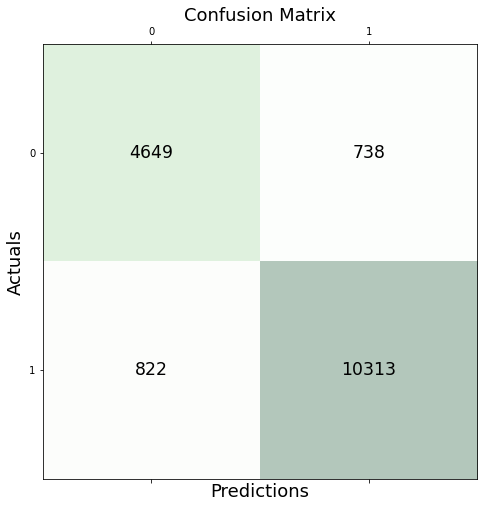

In [29]:
# confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_matrix, cmap=plt.cm.Greens, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()